In [1]:
import os
from torch import zeros, tensor
from utils.data_processing import get_mimic_dataset, get_mimic_dataloaders

In [2]:

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.475
valid_frac = 0.2
test_frac = 0.2
early_stop_frac = 0.125
batch_size = 256

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac , 
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac
                                                                            )
                                                                            

In [3]:

train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices, 
                                                            validation_indices, 
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

In [4]:
from utils.grud import *

best_hyperparams ={
    'cell_size': 58,
    'hidden_size': 78, 
    'learning_rate': 0.004738759319792616,
    'num_epochs':37,
    'patience': 3,
    'batch_size': 256,
    'early_stop_frac': 0.125,
    'seed': 4410,
}
early_stop_frac = valid_frac
n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

model_params = {k: best_hyperparams[k] for k in ['cell_size', 'hidden_size', 'batch_size']}

# Add other required parameters to model_params
model_params.update({
    'input_size': n_features,
    'X_mean': X_mean,
    'output_last': False
})



In [5]:
X_mean.shape

torch.Size([1, 24, 104])

In [6]:
from tqdm import tqdm
# Initialize the model with filtered parameters
model = GRUD(**model_params)
# Train the model with Train_Model function
train_losses, test_losses = gru_trained_model_and_metadata(
            model, train_loader, early_stop_loader,
            epochs=best_hyperparams['num_epochs'], 
            patience=best_hyperparams['patience'], 
             min_delta = 1e-5,
            learning_rate=best_hyperparams['learning_rate'], 
            batch_size=best_hyperparams['batch_size'],  # This might be used in your dataloaders, not directly in Train_Model
             metadata = None)
        
            
# best_model,  [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid ]= Train_Model(
#     model, train_loader, early_stop_loader,
#     num_epochs=best_hyperparams['num_epochs'], 
#     patience=best_hyperparams['patience'], 
#     learning_rate=best_hyperparams['learning_rate'], 
#     batch_size=best_hyperparams['batch_size']  # This might be used in your dataloaders, not directly in Train_Model
# )



Model Structure:  GRUD(
  (zl): Linear(in_features=286, out_features=78, bias=True)
  (rl): Linear(in_features=286, out_features=78, bias=True)
  (hl): Linear(in_features=286, out_features=78, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=78, bias=True)
  (fc): Linear(in_features=78, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Start Training ... 


Training Progress:   3%|▎         | 1/37 [00:03<01:51,  3.10s/it]

Epoch: 0, train_loss: 0.57651263, valid_loss: 0.57651263, time: 3.1, best model: 1


Training Progress:   5%|▌         | 2/37 [00:05<01:34,  2.70s/it]

Epoch: 1, train_loss: 0.5736686, valid_loss: 0.5736686, time: 2.43, best model: 1


Training Progress:   8%|▊         | 3/37 [00:07<01:28,  2.59s/it]

Epoch: 2, train_loss: 0.59168547, valid_loss: 0.59168547, time: 2.46, best model: 0


Training Progress:  11%|█         | 4/37 [00:10<01:27,  2.66s/it]

Epoch: 3, train_loss: 0.58693731, valid_loss: 0.58693731, time: 2.76, best model: 0


Training Progress:  11%|█         | 4/37 [00:12<01:45,  3.19s/it]

Early Stopped at Epoch: 4


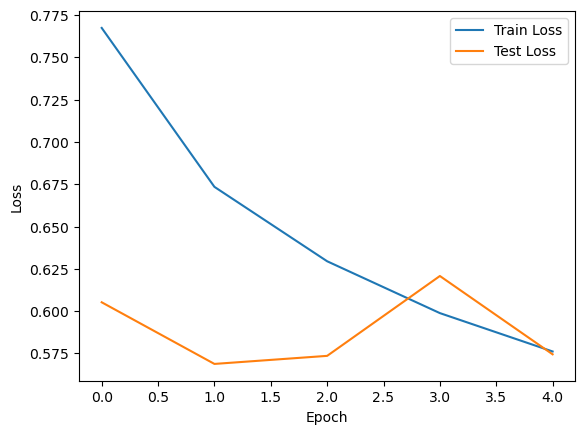

In [7]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot the losses
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(test_losses_cpu, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [8]:
from mimic_gru_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit 
leakpro.run_audit()

2024-11-11 15:34:12,326 INFO     Target model blueprint created from GRUD in utils/grud.py.
2024-11-11 15:34:12,416 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2024-11-11 15:34:12,455 INFO     Loaded target model from ./target
2024-11-11 15:34:13,667 INFO     Loaded population dataset from ./data/dataset.pkl
2024-11-11 15:34:13,668 INFO     Loaded population dataset from ./data/dataset.pkl
2024-11-11 15:34:13,670 INFO     Added attack: lira
2024-11-11 15:34:13,670 INFO     Preparing attack: lira
2024-11-11 15:34:13,686 INFO     Number of existing models exceeds or equals the number of models to create
2024-11-11 15:34:13,688 INFO     Loading shadow model 15
2024-11-11 15:34:13,765 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_15.pkl
2024-11-11 15:34:13,767 INFO     Loading shadow model 14
2024-11-11 15:34:13,844 INFO     Loaded model from ./leakpro_output/attack_objects/shadow_model/shadow_model_14.pkl
2024-11-11 15:34:1

In [ ]:
probabilities_dev, labels_dev = predict_proba(best_model, validation_loader)
probabilities_dev = np.concatenate(probabilities_dev)[:, 1]
labels_dev        = np.concatenate(labels_dev)
s = roc_auc_score(labels_dev, probabilities_dev)

In [ ]:
s

In [ ]:

RERUN            = False

for n, X_train, X_dev, X_test in (
    ('lvl2', lvl2_train, lvl2_dev, lvl2_test),
#         ('raw', raw_train, raw_dev, raw_test)
):
    print("Running model %s on target %s with representation %s" % (model_name, t, n))
    X_mean = np.mean(X_train.loc[:, pd.IndexSlice[:, 'mean']] * 
            np.where((X_train.loc[:, pd.IndexSlice[:, 'mask']] == 1).values, 1, np.NaN), axis=0)
    X_mean = torch.Tensor(np.array([X_mean.values] * WINDOW_SIZE )).unsqueeze(0)
    assert (abs(X_mean) < 2e-10).all() , "X_mean should be zero"
    
    base_params = {'X_mean': X_mean, 'output_last': True, 'input_size': X_mean.shape[2]}

    if n in results[model_name][t]:
        if not RERUN: 
            print("Final results for model %s on target %s with representation %s" % (model_name, t, n))
            print(results[model_name][t][n])
            continue
        best_s, best_hyperparams = results[model_name][t][n][-1], results[model_name][t][n][1]
        print("Loading best hyperparams", best_hyperparams)
    else:
        best_s, best_hyperparams = -np.Inf, None
        for i, hyperparams in enumerate(hyperparams_list):
            print("On sample %d / %d (hyperparams = %s)" % (i+1, len(hyperparams_list), repr((hyperparams))))

            early_stop_frac,batch_size,seed = [hyperparams[k] for k in ('early_stop_frac','batch_size','seed')]

            np.random.seed(seed)
            all_train_subjects = list(
                np.random.permutation(Ys_train.index.get_level_values('subject_id').values)
            )
            N_early_stop        = int(len(all_train_subjects) * early_stop_frac)
            train_subjects      = all_train_subjects[:-N_early_stop]
            early_stop_subjects = all_train_subjects[-N_early_stop:]
            X_train_obs         = X_train[X_train.index.get_level_values('subject_id').isin(train_subjects)]
            Ys_train_obs        = Ys_train[Ys_train.index.get_level_values('subject_id').isin(train_subjects)]

            X_train_early_stop  = X_train[X_train.index.get_level_values('subject_id').isin(early_stop_subjects)]
            Ys_train_early_stop = Ys_train[
                Ys_train.index.get_level_values('subject_id').isin(early_stop_subjects)
            ]

            train_dataloader      = prepare_dataloader(X_train_obs, Ys_train_obs[t], batch_size=batch_size)
            early_stop_dataloader = prepare_dataloader(
                X_train_early_stop, Ys_train_early_stop[t], batch_size=batch_size
            )
            dev_dataloader        = prepare_dataloader(X_dev, Ys_dev[t], batch_size=batch_size)
            test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

            model_hyperparams = copy.copy(base_params)
            model_hyperparams.update(
                {k: v for k, v in hyperparams.items() if k in ('cell_size', 'hidden_size', 'batch_size')}
            )
            model = GRUD(**model_hyperparams)

            best_model, _ = Train_Model(
                model, train_dataloader, early_stop_dataloader,
                **{k: v for k, v in hyperparams.items() if k in (
                    'num_epochs', 'patience', 'learning_rate', 'batch_size'
                )}
            )

            probabilities_dev, labels_dev = predict_proba(best_model, dev_dataloader)
            probabilities_dev = np.concatenate(probabilities_dev)[:, 1]
            labels_dev        = np.concatenate(labels_dev)
            s = roc_auc_score(labels_dev, probabilities_dev)
            if s > best_s:
                best_s, best_hyperparams = s, hyperparams
                print("New Best Score: %.2f @ hyperparams = %s" % (100*best_s, repr((best_hyperparams))))
            
    ## Test
    np.random.seed(seed)
    hyperparams = best_hyperparams # In case I forgot a replace below
    early_stop_frac,batch_size,seed = [best_hyperparams[k] for k in ('early_stop_frac','batch_size','seed')]
    
    X_train_concat, Ys_train_concat = pd.concat((X_train, X_dev)), pd.concat((Ys_train, Ys_dev))
    
    all_train_subjects = list(np.random.permutation(Ys_train_concat.index.get_level_values('subject_id').values))
    N_early_stop = int(len(all_train_subjects) * early_stop_frac)
    train_subjects, early_stop_subjects = all_train_subjects[:-N_early_stop], all_train_subjects[-N_early_stop:]
    X_train_obs         = X_train_concat[X_train_concat.index.get_level_values('subject_id').isin(train_subjects)]
    Ys_train_obs        = Ys_train_concat[Ys_train_concat.index.get_level_values('subject_id').isin(train_subjects)]

    X_train_early_stop  = X_train_concat[X_train_concat.index.get_level_values('subject_id').isin(early_stop_subjects)]
    Ys_train_early_stop = Ys_train_concat[Ys_train_concat.index.get_level_values('subject_id').isin(early_stop_subjects)]

    train_dataloader      = prepare_dataloader(X_train_obs, Ys_train_obs[t], batch_size=batch_size)
    early_stop_dataloader = prepare_dataloader(X_train_early_stop, Ys_train_early_stop[t], batch_size=batch_size)
    test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

    model_hyperparams = copy.copy(base_params)
    model_hyperparams.update(
        {k: v for k, v in best_hyperparams.items() if k in ('cell_size', 'hidden_size', 'batch_size')}
    )
    model = GRUD(**model_hyperparams)

    best_model, (losses_train, losses_early_stop, losses_epochs_train, losses_epochs_early_stop) = Train_Model(
        model, train_dataloader, early_stop_dataloader,
        **{k: v for k, v in best_hyperparams.items() if k in (
            'num_epochs', 'patience', 'learning_rate', 'batch_size'
        )}
    )

    probabilities_test, labels_test = predict_proba(best_model, test_dataloader)
    
    probabilities_test = np.array(probabilities_test)
    labels_test = np.array(labels_test).reshape(-1)
    

    y_score = probabilities_test.reshape(-1, 2)[:, 1]  # Probability for the positive class
    y_pred = np.argmax(probabilities_test.reshape(-1, 2), axis=1)  # Predicted class labels

    auc = roc_auc_score(labels_test, y_score)
    auprc = average_precision_score(labels_test, y_score)
    acc = accuracy_score(labels_test, y_pred)
    F1    = f1_score(labels_test, y_pred)
    print("Final results for model %s on target %s with representation %s" % (model_name, t, n))
    print(auc, auprc, acc, F1)
    
    results[model_name][t][n] = None, best_hyperparams, auc, auprc, acc, F1, best_s
    with open('./scratch/extraction_baselines_gru-d.pkl', mode='wb') as f: pickle.dump(results, f)

In [ ]:
# Extract only the relevant parameters for GRUD
model_params = {k: best_hyperparams[k] for k in ['cell_size', 'hidden_size', 'batch_size']}

# Add other required parameters to model_params
model_params.update({
    'input_size': <your_input_size>,      # e.g., 58, replace <your_input_size> with your value
    'X_mean': <your_X_mean>,              # replace <your_X_mean> with your actual X_mean array
    'output_last': False                  # or True, depending on your preference
})

# Initialize the model with filtered parameters
model = GRUD(**model_params)

In [ ]:

best_model, (losses_train, losses_early_stop, losses_epochs_train, losses_epochs_early_stop) = Train_Model(
            model, train_dataloader, early_stop_dataloader,
            **{k: v for k, v in best_hyperparams.items() if k in (
                'num_epochs', 'patience', 'learning_rate', 'batch_size'
            )}
        )


n_features = dataset.x.shape[1]
print(f"Number of features: {n_features}")

# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
model = Mimic(n_features)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model, 
                                                                               train_loader, 
                                                                               test_loader, 
                                                                               lr = 0.0001,
                                                                                weight_decay = 5.392,
                                                                               epochs=5)